Source: @DeepCharts Youtube Channel (https://www.youtube.com/@DeepCharts)

# Import Data

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
print(sys.executable)


D:\IT Project\flightenv\Scripts\python.exe


In [4]:
# !pip install seaborn

In [5]:
# cd "/path/to/your/data/"

In [6]:
df = pd.read_csv('Flight_delay.csv')

In [7]:
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


# Select Columns

In [8]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


# Check for missing data

In [9]:
df.isnull().sum()

DayOfWeek       0
Date            0
DepTime         0
Airline         0
Origin          0
Dest            0
CarrierDelay    0
dtype: int64

# Convert Date Column to Pandas Datetime

In [10]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Create Month And Day Feature

In [11]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

### Drop Date now

In [12]:

# Drop the original 'Date' column since XGBoost doesn't handle datetime types
df = df.drop(columns=['Date'])

In [13]:
df

,DayOfWeek,DepTime,Airline,Origin,Dest,CarrierDelay,month,day
0,4,1829,Southwest Airlines Co.,IND,BWI,2,1,3
1,4,1937,Southwest Airlines Co.,IND,LAS,10,1,3
2,4,1644,Southwest Airlines Co.,IND,MCO,8,1,3
3,4,1452,Southwest Airlines Co.,IND,PHX,3,1,3
4,4,1323,Southwest Airlines Co.,IND,TPA,0,1,3
...,...,...,...,...,...,...,...,...
484546,5,1609,American Airlines Inc.,DFW,MCO,27,6,13
484547,6,1616,American Airlines Inc.,DFW,MCO,11,6,14
484548,2,1617,American Airlines Inc.,DFW,MCO,0,6,17
484549,7,1607,American Airlines Inc.,DFW,MCO,1,6,22


# Identify Categorical variables

In [14]:
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

# One-Hot Encoding (Dummy Variables) for Categorical Data

In [15]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded

,DayOfWeek,DepTime,CarrierDelay,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,4,1829,2,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1937,10,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4,1644,8,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1452,3,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,1323,0,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484546,5,1609,27,6,13,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484547,6,1616,11,6,14,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484548,2,1617,0,6,17,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484549,7,1607,1,6,22,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Prepare Target Variable(s)

In [16]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)
# df_encoded['is_delayed_15+'] = np.where(df_encoded['CarrierDelay'] > 30, 1, 0)
df_encoded

,DayOfWeek,DepTime,CarrierDelay,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,...,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,is_delayed_60+
0,4,1829,2,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,4,1937,10,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,4,1644,8,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,4,1452,3,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,4,1323,0,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484546,5,1609,27,6,13,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484547,6,1616,11,6,14,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484548,2,1617,0,6,17,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484549,7,1607,1,6,22,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


# Define features and target variable


In [17]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']
X,y

(        DayOfWeek  DepTime  month  day  Airline_American Airlines Inc.  \
 0               4     1829      1    3                           False   
 1               4     1937      1    3                           False   
 2               4     1644      1    3                           False   
 3               4     1452      1    3                           False   
 4               4     1323      1    3                           False   
 ...           ...      ...    ...  ...                             ...   
 484546          5     1609      6   13                            True   
 484547          6     1616      6   14                            True   
 484548          2     1617      6   17                            True   
 484549          7     1607      6   22                            True   
 484550          1     1608      6   23                            True   
 
         Airline_American Eagle Airlines Inc.  \
 0                                      False   


# Split the data into training and testing sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Exploratory Data Analysis

### Put Train X and y together

In [19]:
train_set = pd.concat([X_train, y_train], axis= 1)

### Undo one-hot encoding

In [20]:
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [21]:
# Reversing one-hot encoding for multiple sets of categorical variables
for category in categories:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
    train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
    train_set = train_set.drop(columns=one_hot_columns)
    train_set[category] = train_set[category].str.replace(f'{category}_', '')

In [22]:
train_set

,DayOfWeek,DepTime,month,day,is_delayed_60+,Airline,Origin,Dest
132504,5,2124,2,22,0,US Airways Inc.,PHX,LAS
483050,4,2218,6,19,0,American Airlines Inc.,DFW,OAK
318401,6,1500,4,26,1,American Airlines Inc.,ORD,MIA
259287,3,2112,3,12,1,American Airlines Inc.,JNU,SEA
77835,6,1730,1,26,0,American Airlines Inc.,SJU,ORD
...,...,...,...,...,...,...,...,...
439107,4,1707,6,19,0,United Air Lines Inc.,PIT,ORD
117952,3,1752,2,27,0,Skywest Airlines Inc.,ORD,LAN
435829,2,1826,6,24,0,United Air Lines Inc.,LAX,ORD
305711,1,1350,4,21,0,Atlantic Southeast Airlines,SAT,ATL


### Check distribution of target variable

In [23]:
train_set['is_delayed_60+'].value_counts()

is_delayed_60+
0    313876
1     25309
Name: count, dtype: int64

In [24]:
train_set['is_delayed_60+'].mean()

np.float64(0.07461709686454294)

### Delays by Airline

In [25]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

Airline
Atlantic Southeast Airlines     16.3
Hawaiian Airlines Inc.          14.2
Skywest Airlines Inc.           10.3
American Airlines Inc.           9.0
Delta Air Lines Inc.             8.4
US Airways Inc.                  7.6
United Air Lines Inc.            7.5
American Eagle Airlines Inc.     7.0
JetBlue Airways                  5.9
Frontier Airlines Inc.           4.7
Southwest Airlines Co.           3.3
Name: is_delayed_60+, dtype: float64

### Delays by Day of the Week

In [26]:
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

DayOfWeek
1    7.6
2    7.1
3    7.6
4    6.9
5    6.8
6    9.0
7    7.9
Name: is_delayed_60+, dtype: float64

### Delays by Origin Airport

In [27]:
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)

Origin
ACY    40.0
LWB    40.0
MQT    33.8
MCN    27.8
SLE    26.7
SCE    25.0
PFN    23.6
PHF    23.1
MKG    22.6
TRI    22.5
MEI    22.2
HHH    21.8
OAJ    21.5
FAY    21.4
ROW    21.4
VLD    20.3
AVL    19.8
ABI    19.4
EWN    19.3
CMI    18.4
Name: is_delayed_60+, dtype: float64

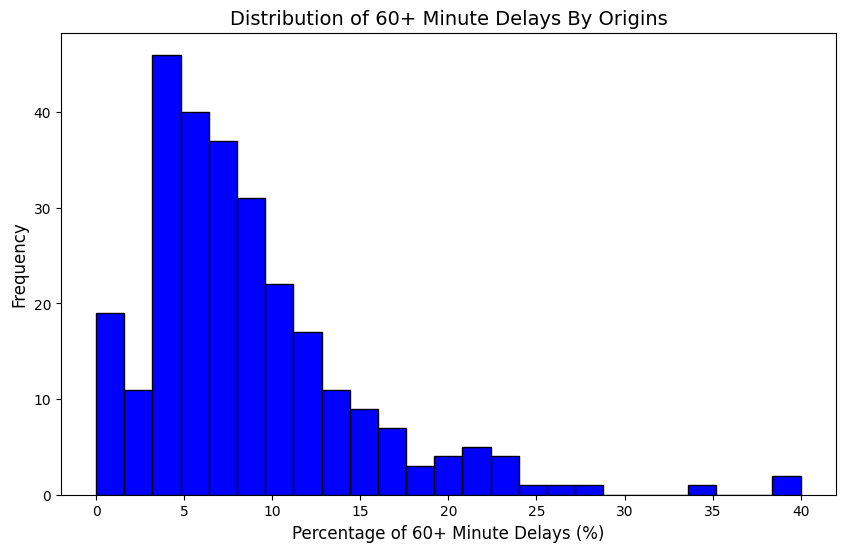

In [28]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

# Initialize and Fit the XGBoost classifier (baseline model)

In [29]:
scale = (len(y_train) - sum(y_train)) / sum(y_train)
print(scale)

#xgb_model = xgb.XGBClassifier(random_state=0, eval_metric='logloss')
xgb_model = xgb.XGBClassifier(
    random_state=0,
    eval_metric='logloss',
    
)

12.401754316646253


In [30]:
xgb_model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set

In [ ]:
y_pred = xgb_model.predict(X_test)
import numpy as np
np.set_printoptions(threshold=np.inf)

print(y_pred)



In [ ]:
X_test.columns

In [ ]:
# 1) Quick diagnostics: show object columns and dtype summary
obj_cols = X_test.select_dtypes(include=['object']).columns.tolist()
print("Object dtype columns in X_test:", len(obj_cols))
print(obj_cols[:50])            # show up to first 50 names

print("\nX_train dtypes value counts:")
print(X_train.dtypes.value_counts())
print("\nX_test dtypes value counts:")
print(X_test.dtypes.value_counts())


In [ ]:
df_60plus = df_encoded[df_encoded['is_delayed_60+'] == 1]



In [ ]:
# 1. Filter rows where is_delayed_60+ = 1
df_60plus = df_encoded[df_encoded['is_delayed_60+'] == 1]

# 2. Select one row (keep DataFrame)
sample_row = df_60plus.iloc[[0]].drop(columns=['is_delayed_60+']).copy()

# 3. Align columns to X_train
train_cols = list(X_train.columns)

# Add any missing columns (should be none ideally)
for col in train_cols:
    if col not in sample_row.columns:
        sample_row[col] = 0

# Drop any extra columns (should be none)
for col in sample_row.columns:
    if col not in train_cols:
        sample_row = sample_row.drop(columns=[col])

# Reorder columns to match training data
sample_row = sample_row[train_cols]

# 4. Predict
prediction = xgb_model.predict(sample_row)
proba = xgb_model.predict_proba(sample_row)[:, 1]

# 5. Print result
print("Prediction:", prediction)
print("Probability:", proba)


# Evaluate the model

In [ ]:
print("XGBoost Classifier (Baseline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

In [ ]:
import json

path = r"D:\IT Project\model_features.json"

with open(path, "w") as f:
    json.dump(list(X_train.columns), f)

print("Wrote", path)


In [ ]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

In [ ]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Do Cross-Validated Grid Search

In [ ]:
# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.2],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 250],
#     'subsample': [0.6,  1.0]
# }

# # Initialize the XGBoost model
# xgb_model = xgb.XGBClassifier(random_state=0,
#                               eval_metric='logloss')

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, 
#                            param_grid=param_grid, 
#                            cv=3, 
#                            scoring='roc_auc', 
#                            verbose=1, 
#                            n_jobs=1)

# # Fit the grid search model
# grid_search.fit(X_train, y_train)


# Evaluate best parameters and predict on training set

In [ ]:

# # Best parameters from GridSearch
# print("Best parameters found: ", grid_search.best_params_)

# # Predict with the best model
# y_pred_best = grid_search.best_estimator_.predict(X_test)

# # Evaluate the tuned XGBoost model
# print("XGBoost Classifier (Tuned):")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

In [ ]:
# Confusion matrix
# cm = confusion_matrix(y_test, y_pred_best)
# cm

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Example: using XGBoost classifier
# xgb_model = xgb.XGBClassifier(random_state=0)

# # Define hyperparameters to tune
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2)

# # Fit it on training data
# grid_search.fit(X_train, y_train)

# # Predict probabilities for the test set (to calculate AUC)
# y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# # Calculate the AUC score
# auc_score = roc_auc_score(y_test, y_pred_proba)
# print(f"AUC Score: {auc_score:.4f}")

In [ ]:
# # Plot the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('ROC Curve')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()